In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time

import healpy as hp
import pandas as pd
from sklearn.neighbors import KDTree

In [2]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

## Read in data

In [3]:
tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
print('Total number of Gaia quasars:', len(tab_gaia))

Total number of Gaia quasars: 6649162


In [4]:
tab_gaia.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','astrometric_excess_noise','visibility_periods_used','ipd_frac_multi_peak','ruwe','phot_g_n_obs','phot_g_mean_flux','phot_g_mean_flux_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_rp_excess_factor','in_qso_candidates','gaia_crf_source','vari_best_class_name','vari_best_class_score','fractional_variability_g','qso_variability','non_qso_variability','vari_agn_membership_score','classprob_dsc_combmod_quasar','classprob_dsc_combmod_galaxy','classlabel_dsc','classlabel_dsc_joint','classlabel_oa','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','n_transits','intensity_quasar','intensity_quasar_error','host_galaxy_detected','intensity_hostgalaxy','intensity_hostgalaxy_error','radius_hostgalaxy','radius_hostgalaxy_error','host_galaxy_flag','source_selection_flags','allwise_oid','designation','w1mpro','w2mpro','

In [5]:
tab_sdss = Table.read('../data/SDSS_DR16Q_v4.fits', format='fits') 
print('Total number of SDSS quasars:', len(tab_sdss))

Total number of SDSS quasars: 750414


In [6]:
tab_sdss.columns

<TableColumns names=('SDSS_NAME','RA','DEC','PLATE','MJD','FIBERID','AUTOCLASS_PQN','AUTOCLASS_DR14Q','IS_QSO_QN','Z_QN','RANDOM_SELECT','Z_10K','Z_CONF_10K','PIPE_CORR_10K','IS_QSO_10K','THING_ID','Z_VI','Z_CONF','CLASS_PERSON','Z_DR12Q','IS_QSO_DR12Q','Z_DR7Q_SCH','IS_QSO_DR7Q','Z_DR6Q_HW','Z_DR7Q_HW','IS_QSO_FINAL','Z','SOURCE_Z','Z_PIPE','ZWARNING','OBJID','Z_PCA','ZWARN_PCA','DELTACHI2_PCA','Z_HALPHA','ZWARN_HALPHA','DELTACHI2_HALPHA','Z_HBETA','ZWARN_HBETA','DELTACHI2_HBETA','Z_MGII','ZWARN_MGII','DELTACHI2_MGII','Z_CIII','ZWARN_CIII','DELTACHI2_CIII','Z_CIV','ZWARN_CIV','DELTACHI2_CIV','Z_LYA','ZWARN_LYA','DELTACHI2_LYA','Z_LYAWG','Z_DLA','NHI_DLA','CONF_DLA','BAL_PROB','BI_CIV','ERR_BI_CIV','AI_CIV','ERR_AI_CIV','BI_SIIV','ERR_BI_SIIV','AI_SIIV','ERR_AI_SIIV','BOSS_TARGET1','EBOSS_TARGET0','EBOSS_TARGET1','EBOSS_TARGET2','ANCILLARY_TARGET1','ANCILLARY_TARGET2','NSPEC_SDSS','NSPEC_BOSS','NSPEC','PLATE_DUPLICATE','MJD_DUPLICATE','FIBERID_DUPLICATE','SPECTRO_DUPLICATE','SKYVERSION

Include only SDSS quasars with z>0.01 (this removes zeros and nans, and maybe a few others)

In [7]:
z_min = 0.01
idx_sdssgood = tab_sdss['Z'] > z_min
tab_sdss = tab_sdss[idx_sdssgood]
print(f'Number of SDSS quasars with: z > {z_min}: {len(tab_sdss)}')

Number of SDSS quasars with: z > 0.01: 750397


Cross-match SDSS and Gaia

First two return values of search_around_sky:

idx1: Indices into coords1 that matches to the corresponding element of idx2. Shape matches idx2.

idx2:Indices into coords2 that matches to the corresponding element of idx1. Shape matches idx1

In [8]:
coords_sdss = SkyCoord(ra=tab_sdss['RA']*u.degree, dec=tab_sdss['DEC']*u.degree, frame='icrs')    
coords_gaia = SkyCoord(ra=tab_gaia['ra'], dec=tab_gaia['dec'], frame='icrs') 
cross_sdss_gaia = coords_gaia.search_around_sky(coords_sdss, 1*u.arcsec) # Hogg thinks this is idiotic

Make new table, tab_xmatch, with only gaia objects with SDSS match

In [9]:
tab_gaia_with_sdss_match = tab_gaia[cross_sdss_gaia[1]]

In [10]:
print(f'Number of Gaia quasars: {len(tab_gaia)}')
print(f'Number of SDSS quasars (with z min cut): {len(tab_sdss)}')
print(f'Number of Gaia quasars with SDSS match (with z min cut): {len(tab_gaia_with_sdss_match)}')

Number of Gaia quasars: 6649162
Number of SDSS quasars (with z min cut): 750397
Number of Gaia quasars with SDSS match (with z min cut): 407236


In [11]:
#tab_xmatch.add_column(tab_sdss['Z'], name='redshift_sdss')

## Healpix maps

In [12]:
# copied from https://stackoverflow.com/questions/49372918/group-numpy-into-multiple-sub-arrays-using-an-array-of-values
def groupby(values, group_indices):
    # Get argsort indices, to be used to sort a and b in the next steps
    sidx = group_indices.argsort(kind='mergesort')
    values_sorted = values[sidx]
    group_indices_sorted = group_indices[sidx]

    # Get the group limit indices (start, stop of groups)
    cut_idx = np.flatnonzero(np.r_[True,group_indices_sorted[1:] != group_indices_sorted[:-1],True])

    # Split input array with those start, stop ones
    values_grouped = [values_sorted[i:j] for i,j in zip(cut_idx[:-1],cut_idx[1:])]
    return values_grouped, list(set(group_indices_sorted))

In [13]:
def get_map_nqso(NSIDE, NPIX, ra, dec):
    pixel_indices = hp.ang2pix(NSIDE, ra, dec, lonlat=True)
    
    # ra is just dummy to count 
    ra_grouped, pixel_indices_grouped = groupby(ra, pixel_indices)
    n_per_pixel = np.array([len(ras) for ras in ra_grouped])
    
    map_nqso = np.zeros(NPIX)
    map_nqso[pixel_indices_grouped] = n_per_pixel

    pixel_arr = np.arange(NPIX)
    pixels_nodata = list(set(pixel_arr) - set(pixel_indices_grouped))
    map_nqso[pixels_nodata] = np.nan
    
    return map_nqso, pixel_indices, pixel_indices_grouped

In [14]:
NSIDE = 62
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

46128


In [15]:
map_nqso_sdss, pixel_indices_sdss, pixel_indices_grouped_sdss = get_map_nqso(NSIDE, NPIX, tab_sdss['RA'], tab_sdss['DEC'])

In [16]:
n_pixels_with_qsos = len(pixel_indices_grouped_sdss)
area_sdss = n_pixels_with_qsos*hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)
print(area_sdss)

11462.435057531366


0.0 180.0 -180.0 180.0


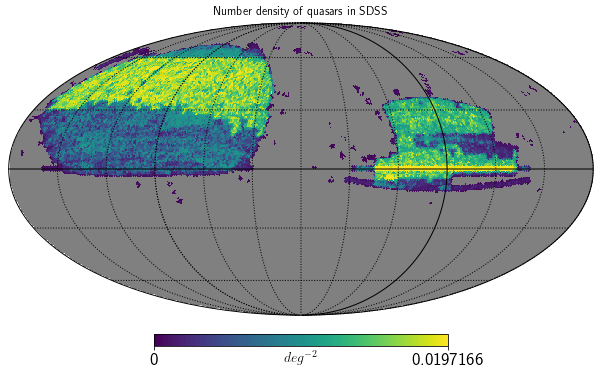

In [17]:
hp.mollview(
    map_nqso_sdss/area_sdss,
    title=r"Number density of quasars in SDSS",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    rot=(90, 0, 0),
    #coord=['C', 'G']
    min=0,
    #max=1,
)
hp.graticule()

In [18]:
map_qso_gaia, pixel_indices_gaia, pixel_indices_grouped_gaia = get_map_nqso(NSIDE, NPIX, tab_gaia['ra'], tab_gaia['dec'])

In [21]:
idx_gaiaINsdss = np.in1d(pixel_indices_gaia, pixel_indices_grouped_sdss)
print(np.sum(idx_gaiaINsdss)/len(idx_gaiaINsdss))

0.211603808118978


In [22]:
tab_gaiaINsdss = tab_gaia[idx_gaiaINsdss]

In [23]:
map_qso_gaiaINsdss, pixel_indices_gaiaINsdss, pixel_indices_grouped_gaiaINsdss = get_map_nqso(NSIDE, NPIX,
                                                                                   tab_gaiaINsdss['ra'],
                                                                                   tab_gaiaINsdss['dec'])

0.0 180.0 -180.0 180.0


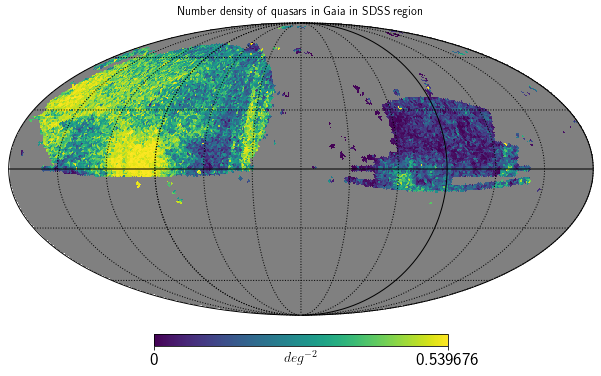

In [24]:
hp.mollview(
    map_qso_gaiaINsdss/area_sdss,
    title=rf"Number density of quasars in Gaia in SDSS region",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    rot=(90, 0, 0),
    #coord=['C', 'G']
    min=0,
    #max=1,
)
hp.graticule()

## Now do the cross-match with Gaia-in-SDSS and SDSS

In [25]:
coords_sdss = SkyCoord(ra=tab_sdss['RA']*u.degree, dec=tab_sdss['DEC']*u.degree, frame='icrs')    
coords_gaiaINsdss = SkyCoord(ra=tab_gaiaINsdss['ra'], dec=tab_gaiaINsdss['dec'], frame='icrs') 
cross_sdss_gaiaINsdss = coords_sdss.search_around_sky(coords_gaiaINsdss, 1*u.arcsec) # Hogg thinks this is idiotic

We have some non-unique matches!

In [26]:
unq, unq_idx, unq_count = np.unique(cross_sdss_gaiaINsdss[0], return_inverse=True, return_counts=True)
count_mask = unq_count > 1
dup_ids = unq[count_mask]
print("Number of SDSS objects with multiple Gaia matches:", len(dup_ids))

Number of SDSS objects with multiple Gaia matches: 4


In [27]:
unq, unq_idx, unq_count = np.unique(cross_sdss_gaiaINsdss[1], return_inverse=True, return_counts=True)
count_mask = unq_count > 1
dup_ids = unq[count_mask]
print("Number of Gaia objects with multiple SDSS matches:", len(dup_ids))

Number of Gaia objects with multiple SDSS matches: 30


Let's ignore these for now...

In [28]:
tab_gaiaANDsdss_direct = tab_gaiaINsdss[cross_sdss_gaiaINsdss[0]]
tab_sdssANDgaia_direct = tab_sdss[cross_sdss_gaiaINsdss[1]]
print(len(tab_gaiaANDsdss_direct), len(tab_sdssANDgaia_direct))

407236 407236


In [29]:
# turn list of index numbers into true-false mask
idx_gaiaINsdss_gaiaANDsdss = np.in1d(np.arange(len(tab_gaiaINsdss)), cross_sdss_gaiaINsdss[0])
idx_sdss_gaiaANDsdss = np.in1d(np.arange(len(tab_sdss)), cross_sdss_gaiaINsdss[1])

tab_gaiaANDsdss = tab_gaiaINsdss[idx_gaiaINsdss_gaiaANDsdss]
tab_sdssANDgaia = tab_sdss[idx_sdss_gaiaANDsdss]
print(len(tab_gaiaANDsdss), len(tab_sdssANDgaia))

tab_gaiaNOTsdss = tab_gaiaINsdss[~idx_gaiaINsdss_gaiaANDsdss]
tab_sdssNOTgaia = tab_sdss[~idx_sdss_gaiaANDsdss]
print(len(tab_gaiaNOTsdss), len(tab_sdssNOTgaia))

407232 407205
999756 343192


In [30]:
len(tab_gaiaANDsdss), len(tab_sdssANDgaia['Z'])

(407232, 407205)

In [31]:
print(len(tab_gaiaANDsdss)+len(tab_gaiaNOTsdss))
print(len(tab_gaiaINsdss))
print(len(tab_sdssANDgaia)+len(tab_sdssNOTgaia))
print(len(tab_sdss))

1406988
1406988
750397
750397


In [32]:
indices_gaiaINsdss_gaiaANDsdss = np.intersect1d(np.arange(len(tab_gaiaINsdss)), cross_sdss_gaiaINsdss[0])
len(indices_gaiaINsdss_gaiaANDsdss)

407232

In [33]:
indices_sdss_gaiaANDsdss = np.intersect1d(np.arange(len(tab_sdss)), cross_sdss_gaiaINsdss[1])
len(indices_gaiaINsdss_gaiaANDsdss)

407232

In [34]:
print(f'Number of quasars in SDSS: {len(tab_sdss)}')
print(f'Number of quasars in Gaia: {len(tab_gaia)}')
print(f'Number of quasars in Gaia in the SDSS region: {len(tab_gaiaINsdss)}')
print(f'Number of quasars in both Gaia and SDSS: {len(tab_gaiaANDsdss)}')
print(f'Number of quasars in Gaia in SDSS region and not SDSS: {len(tab_gaiaNOTsdss)}')
print(f'Number of quasars in SDSS and not Gaia: {len(tab_sdssNOTgaia)}')

Number of quasars in SDSS: 750397
Number of quasars in Gaia: 6649162
Number of quasars in Gaia in the SDSS region: 1406988
Number of quasars in both Gaia and SDSS: 407232
Number of quasars in Gaia in SDSS region and not SDSS: 999756
Number of quasars in SDSS and not Gaia: 343192


## Maps of the not-samples

In [35]:
map_qso_gaiaNOTsdss, _, _ = get_map_nqso(NSIDE, NPIX, tab_gaiaNOTsdss['ra'], tab_gaiaNOTsdss['dec'])

0.0 180.0 -180.0 180.0


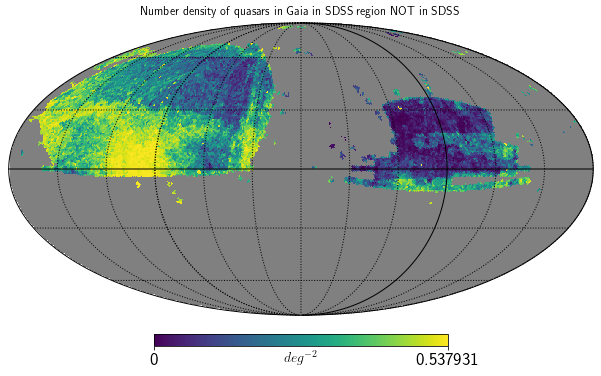

In [36]:
hp.mollview(
    map_qso_gaiaNOTsdss/area_sdss,
    title=rf"Number density of quasars in Gaia in SDSS region NOT in SDSS",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    rot=(90, 0, 0),
    #coord=['C', 'G']
    min=0,
    #max=1,
)
hp.graticule()

0.0 180.0 -180.0 180.0


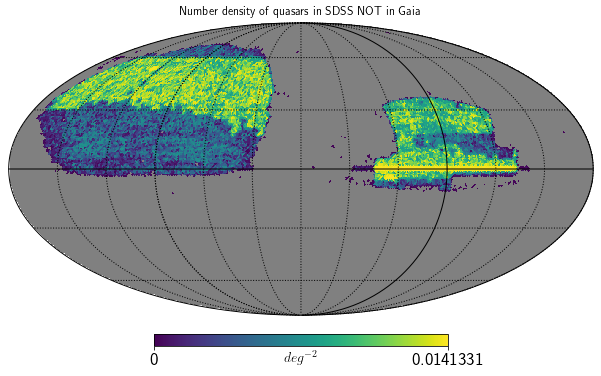

In [37]:
map_qso_sdssNOTgaia, _, _ = get_map_nqso(NSIDE, NPIX, tab_sdssNOTgaia['RA'], tab_sdssNOTgaia['DEC'])

hp.mollview(
    map_qso_sdssNOTgaia/area_sdss,
    title=rf"Number density of quasars in SDSS NOT in Gaia",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    rot=(90, 0, 0),
    #coord=['C', 'G']
    min=0,
    #max=1,
)
hp.graticule()

## Color comparison

In [38]:
def get_gaia_wise_colors(tab, key_mode=None):
    if key_mode is None:
        if 'w1mpro' in tab.columns:
            key_mode = 'gaia'
        elif 'W1_MAG' in tab.columns:
            key_mode = 'sdss'
        else:
            raise ValueError("Can't parse keys!")
    if key_mode=='gaia':
        w1_key, w2_key = 'w1mpro', 'w2mpro'
        g_key = 'phot_g_mean_mag'
    elif key_mode=='sdss':
        w1_key, w2_key = 'W1_MAG', 'W2_MAG'
        g_key = 'GAIA_G_MAG'
    g = tab[g_key]
    w1 = tab[w1_key]
    w2 = tab[w2_key]
    g_w1 = g-w1
    w1_w2 = w1-w2
    
    # bag gs have -1
    small = 1e-6
    idx_ggood = np.abs(g - (-1)) > small
    idx_w1good = (np.abs(w1 - (-1)) > small) & (np.abs(w1) > small)
    
    result = np.array([g_w1, w1_w2, g, w1, w2])
    idx_finite = np.all(np.isfinite(result), axis=0)
    idx_good = idx_ggood & idx_w1good & idx_finite
    
    print("Fraction with good photometry:", np.sum(idx_good)/len(tab))

    return result[:,idx_good]

In [39]:
def get_gaia_colors(tab):
    g_key = 'phot_g_mean_mag'
    bp_key = 'phot_bp_mean_mag'
    rp_key = 'phot_rp_mean_mag'

    g = tab[g_key]
    bp = tab[bp_key]
    rp = tab[rp_key]
    g_rp = g-rp
    bp_g = bp-g
    bp_rp = bp-rp
    
    result = np.array([g_rp, bp_g, bp_rp, g, bp, rp])
    idx_finite = np.all(np.isfinite(result), axis=0)
    print("Fraction with good photometry:", np.sum(idx_finite)/len(tab))

    return result[:,idx_finite]

In [40]:
from matplotlib.lines import Line2D

colors = ['orange', 'saddlebrown', 'blue', 'magenta', 'green']
tables = [tab_gaia, tab_sdss, tab_gaiaANDsdss, tab_gaiaNOTsdss, tab_sdssNOTgaia]
labels = ['Gaia', 'SDSS', 'Gaia and SDSS', 'Gaia not SDSS', 'SDSS not Gaia']
zorders = [0, 2, 3, 1, 4]
legend_elements_markers = [Line2D([0], [0], marker='o', color=colors[i], label=labels[i],
                          markersize=8, ls='None') for i in range(len(colors))]
legend_elements_lines = [Line2D([0], [0], marker=None, color=colors[i], label=f'{labels[i]}',
                          lw=1.5) for i in range(len(colors))]

Fraction with good photometry: 0.258302023623428
Fraction with good photometry: 0.6233726947202614
Fraction with good photometry: 0.8173449041332704
Fraction with good photometry: 0.3480659280864531
Fraction with good photometry: 0.18407188978764075


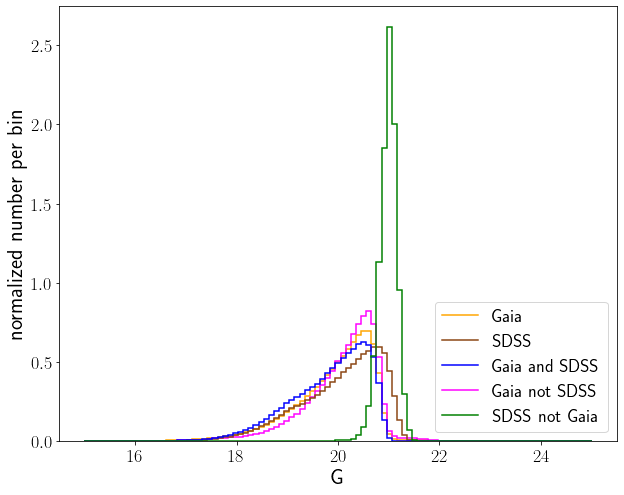

In [41]:
g_bins = np.linspace(15, 25, 100)
plt.figure(figsize=(10,8))
for i in range(len(tables)):
    g_w1, w1_w2, g, w1, w2 = get_gaia_wise_colors(tables[i], key_mode=None)
    plt.hist(g, bins=g_bins,lw=1.5, color=colors[i], label=labels[i], 
             zorder=zorders[i], histtype='step', density=True)

#plt.xlim(-3, 12)
#plt.ylim(-4,4)
plt.xlabel('G')
plt.ylabel('normalized number per bin')
plt.legend(handles=legend_elements_lines, loc='lower right')

In [51]:
# TODO: better cuts! 
cut_0 = 0., 1., 0.2
cut_1 = 1., 1., 2.9

def plot_cut(ax, cut):

    xx = np.array(ax.get_xlim())
    yy = np.array(ax.get_ylim())

    if abs(cut[0]) > abs(cut[1]):
        ax.plot((cut[2] - cut[1]*yy)/cut[0], yy, 'k-')
    else:
        ax.plot(xx, (cut[2] - cut[0]*xx)/cut[1], 'k-')
        
    ax.set_xlim(xx)
    ax.set_ylim(yy)

def cut_index(g_w1, w1_w2, cut):
    return cut[0] * g_w1 + cut[1] * w1_w2 > cut[2]

Fraction with good photometry: 0.258302023623428
Fraction with good photometry: 0.6233726947202614
Fraction with good photometry: 0.8173449041332704
Fraction with good photometry: 0.3480659280864531
Fraction with good photometry: 0.18407188978764075


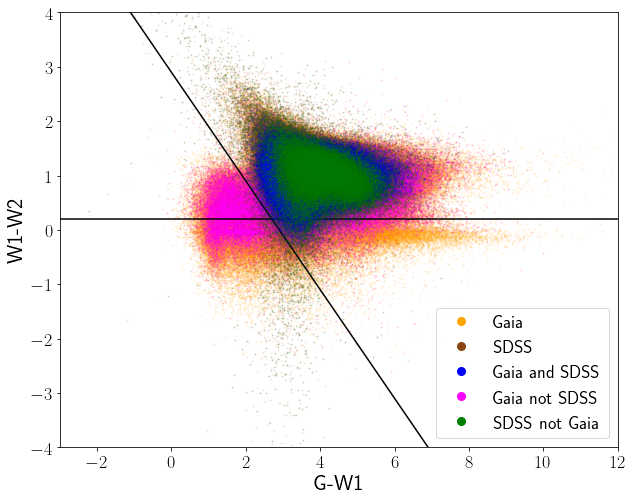

In [52]:
plt.figure(figsize=(10,8))
for i in range(len(tables)):
    g_w1, w1_w2, g, w1, w2 = get_gaia_wise_colors(tables[i], key_mode=None)
    plt.scatter(g_w1, w1_w2, s=1, alpha=0.1, color=colors[i], label=labels[i], zorder=zorders[i])

ax = plt.gca()
plot_cut(ax, cut_0)
plot_cut(ax, cut_1)

plt.xlim(-3, 12)
plt.ylim(-4,4)
plt.xlabel('G-W1')
plt.ylabel('W1-W2')
plt.legend(handles=legend_elements_markers, loc='lower right')

In [61]:
g_w1, w1_w2, g, w1, w2 = get_gaia_wise_colors(tab_gaiaNOTsdss, key_mode=None)
idx_color = cut_index(g_w1, w1_w2, cut_0) & cut_index(g_w1, w1_w2, cut_1)
print(len(tab_gaiaNOTsdss), len(g_w1), np.sum(idx_color))
print("Fraction of Gaia-not-SDSS quasars that make color cuts:", np.sum(idx_color)/len(idx_color))

Fraction with good photometry: 0.3480659280864531
999756 347981 313457
Fraction of Gaia-not-SDSS quasars that make color cuts: 0.9007876866840431


In [65]:
gmag_max = 20
idx_gmag = (tab_gaiaNOTsdss['phot_g_mean_mag'] < gmag_max)
g_w1, w1_w2, g, w1, w2 = get_gaia_wise_colors(tab_gaiaNOTsdss[idx_gmag], key_mode=None)
idx_color = cut_index(g_w1, w1_w2, cut_0) & cut_index(g_w1, w1_w2, cut_1)
print(len(tab_gaiaNOTsdss), len(tab_gaiaNOTsdss[idx_gmag]), np.sum(idx_gmag), len(g_w1), np.sum(idx_color))
print("Fraction of Gaia-not-SDSS quasars with G<20 that make color cuts:", np.sum(idx_color)/len(idx_color))

Fraction with good photometry: 0.5016881469473474
999756 260937 260937 130909 105776
Fraction of Gaia-not-SDSS quasars with G<20 that make color cuts: 0.808011672230328


Fraction with good photometry: 0.258302023623428
Fraction with good photometry: 0.6233726947202614
Fraction with good photometry: 0.8173449041332704
Fraction with good photometry: 0.3480659280864531
Fraction with good photometry: 0.18407188978764075


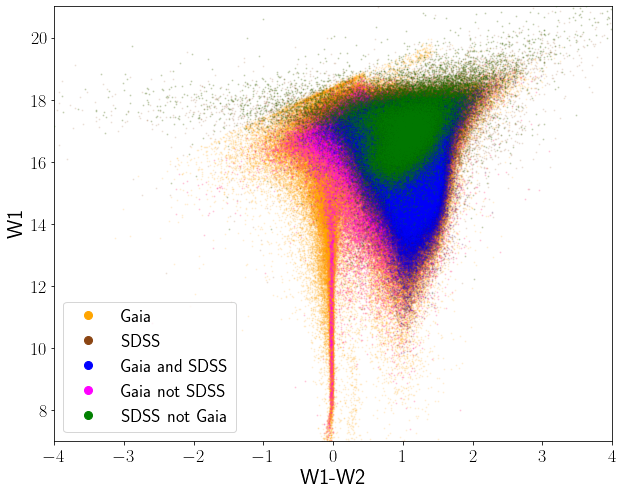

In [48]:
plt.figure(figsize=(10,8))
for i in range(len(tables)):
    g_w1, w1_w2, g, w1, w2 = get_gaia_wise_colors(tables[i], key_mode=None)
    plt.scatter(w1_w2, w1, s=1, alpha=0.1, color=colors[i], label=labels[i], zorder=zorders[i])

plt.xlim(-4,4)
plt.ylim(7, 21)
plt.xlabel('W1-W2')
plt.ylabel('W1')
plt.legend(handles=legend_elements_markers, loc='lower left')

Fraction with good photometry: 0.9695024726424172
Fraction with good photometry: 0.9996709492377809
Fraction with good photometry: 0.9984246156062079


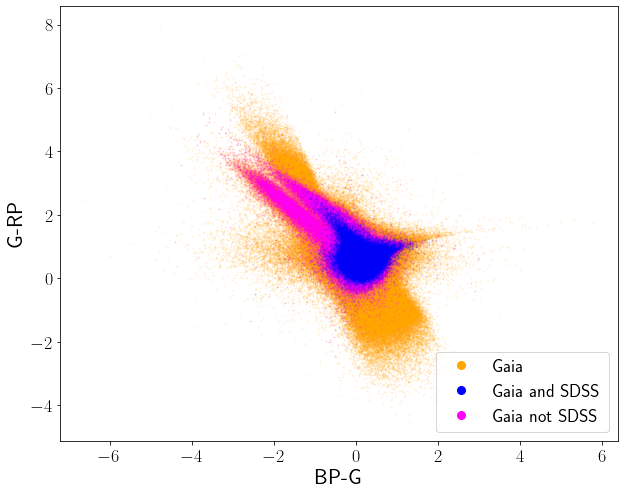

In [44]:
plt.figure(figsize=(10,8))
legend_elements_markers_gaia = []
for i in range(len(tables)):
    if labels[i].startswith('Gaia'):
        g_rp, bp_g, bp_rp, _, _, _ = get_gaia_colors(tables[i])
        plt.scatter(bp_g, g_rp, s=1, alpha=0.1, color=colors[i], label=labels[i], zorder=zorders[i])
        legend_elements_markers_gaia.append(legend_elements_markers[i])
#plt.xlim(-4,4)
#plt.ylim(7, 25)
plt.xlabel('BP-G')
plt.ylabel('G-RP')
plt.legend(handles=legend_elements_markers_gaia, loc='lower right')

## Redshift comparison

In [45]:
def get_redshifts(tab, key_mode=None, return_name=False):
    if key_mode is None:
        if 'w1mpro' in tab.columns:
            key_mode = 'gaia'
        elif 'W1_MAG' in tab.columns:
            key_mode = 'sdss'
        else:
            raise ValueError("Can't parse keys!")
    if key_mode=='gaia':
        z_key = 'redshift_qsoc'
        z_name = 'QSOC redshift'
    elif key_mode=='sdss':
        z_key = 'Z'
        z_name = 'SDSS redshift'
    redshift = tab[z_key]
    if return_name:
        return redshift, z_name
    return redshift

Gaia
SDSS
Gaia and SDSS
Gaia not SDSS
SDSS not Gaia


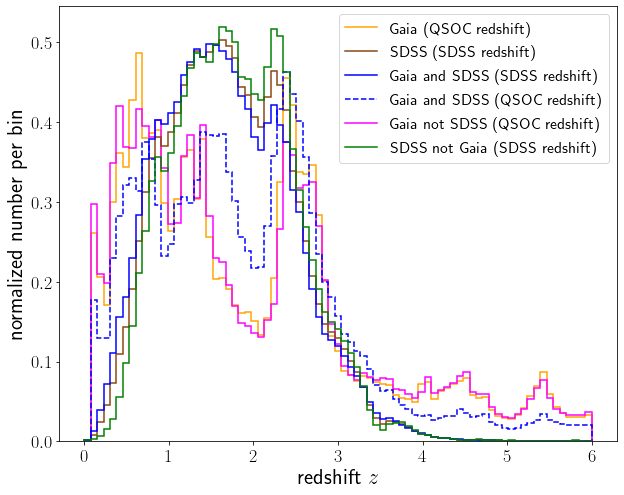

In [46]:
z_bins = np.linspace(0, 6, 80)
legend_elements_lines_z = []
plt.figure(figsize=(10,8))
for i in range(len(tables)):
    print(labels[i])
    if 'and' in labels[i]:
        redshift, z_name = get_redshifts(tab_sdssANDgaia, key_mode='sdss', return_name=True)
        plt.hist(redshift, bins=z_bins, lw=1.5, color=colors[i], 
             zorder=zorders[i], histtype='step', density=True)
        line = Line2D([0], [0], marker=None, color=colors[i], label=f'{labels[i]} ({z_name})', lw=1.5) 
        legend_elements_lines_z.append(line)
        
        redshift, z_name = get_redshifts(tables[i], key_mode='gaia', return_name=True)
        plt.hist(redshift, bins=z_bins, lw=1.5, color=colors[i], ls='--', 
             zorder=zorders[i], histtype='step', density=True)
        line = Line2D([0], [0], marker=None, color=colors[i], label=f'{labels[i]} ({z_name})', lw=1.5, ls='--')
        legend_elements_lines_z.append(line)        
    else:
        redshift, z_name = get_redshifts(tables[i], key_mode=None, return_name=True)
        plt.hist(redshift, bins=z_bins, lw=1.5, color=colors[i], 
             zorder=zorders[i], histtype='step', density=True)
        line = Line2D([0], [0], marker=None, color=colors[i], label=f'{labels[i]} ({z_name})', lw=1.5)
        legend_elements_lines_z.append(line)
        
plt.xlabel('redshift $z$')
plt.ylabel('normalized number per bin')
plt.legend(fontsize=16, handles=legend_elements_lines_z, loc='upper right')

# Angular correlation function

In [49]:
from Corrfunc.theory import DD
from Corrfunc.theory import xi
from Corrfunc.mocks.DDrppi_mocks import DDrppi_mocks
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.utils import convert_rp_pi_counts_to_wp

In [50]:
def compute_wtheta(theta_edges, ra, dec, ra_rand, dec_rand,
                   return_full_results=False):
    
    nthreads = 4
    
    autocorr = 1
    start = time.time()
    DD_theta = DDtheta_mocks(autocorr, nthreads, theta_edges, ra, dec)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    autocorr = 0
    start = time.time()
    DR_theta = DDtheta_mocks(autocorr, nthreads, theta_edges,
                               ra, dec,
                               RA2=ra_rand, DEC2=dec_rand)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    start = time.time()
    autocorr = 1
    RR_theta = DDtheta_mocks(autocorr, nthreads, theta_edges, ra_rand, dec_rand)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    N = len(ra)
    N_rand = len(ra_rand)
    wtheta = convert_3d_counts_to_cf(N, N, N_rand, N_rand,
                                 DD_theta, DR_theta,
                                 DR_theta, RR_theta)
    
    if return_full_results:
        return wtheta, DD_theta, DR_theta, RR_theta
    
    return wtheta

In [252]:
def radec_to_cartesian(r, ra, dec):
    
    theta = ra * np.pi/180
    phi = (90 - dec) * np.pi/180

    x, y, z = spherical_to_cartesian(r, theta, phi)
    return np.array([x, y, z])

In [100]:
def spherical_to_cartesian(r, theta, phi):
    x       =  r*np.cos(theta)*np.sin(phi)
    y       =  r*np.sin(theta)*np.sin(phi)
    z       =  r*np.cos(phi)
    return np.array([x, y, z])